In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
import torch
from torchvision import transforms

dtype = torch.float
device = torch.device("cuda")

## Direct Replication w/ MSE and SGD

### Image

In [4]:
PATH = Path('data/imagenet-sample')
PATH_TRN = PATH/'train'

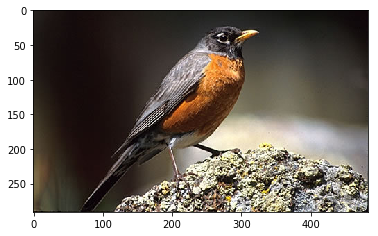

In [75]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

### Noise

In [ ]:
# Initial image - Instead of updating model weights, we'll instead update these pixel values via backprop
noise = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(noise);

### training loop

In [ ]:
v_img = V(img, requires_grad=False)
v_noise = V(noise, requires_grad=True)

opt = torch.optim.SGD([v_noise], lr=1)

In [ ]:
def mse_replicate(input, target, opt):
    for t in range(1000):
        opt.zero_grad()
        loss = torch.nn.functional.mse_loss(input, target)*1000
        loss.backward()
        opt.step()
        
        if t%50==0: print(f'Iteration: {t}, loss: {loss.item()}')
        
#         loss.backward()                # compute gradients
#         with torch.no_grad():          # Update weights using gradient descent
#             lr=1
#             input -= lr * input.grad
#             input.grad.zero_()         # Manually zero the gradients after updating weights

In [ ]:
mse_replicate(v_noise, v_img, opt)
plt.imshow(v_noise.detach().numpy())

## Replication using perceptual loss (vgg layer)

In [6]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()

In [8]:
m_vgg = to_gpu(vgg16(True)).eval()
# m_vgg = vgg16(True).eval()  # cpu
set_trainable(m_vgg, False)
# don't waste time/memory calculating gradients

In [9]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends
# taking batchnorm layers w/ i-2

[5, 12, 22, 32, 42]

In [77]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])   # getting 32nd layer as module
# every forward pass, the 32nd layer's output will be stored in sf.features

### PIL images with torch.transforms (no normalization)

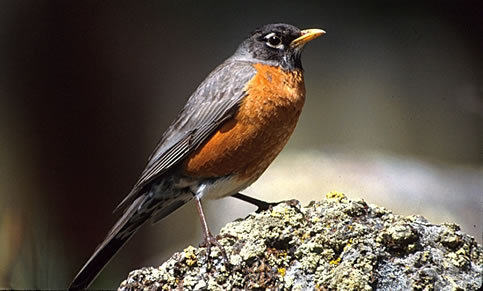

In [123]:
pil_img = Image.open(img_fn)
# need to use PIL instead of open_image - size as tuple instead of int (len of numpy array)
pil_img

In [ ]:
pil_img.size

In [124]:
noise = np.random.uniform(0, 1, size=pil_img.size[::-1]).astype(np.float32) # [::-1] => reverses tuple
pil_noise = Image.fromarray(noise, mode='RGB')

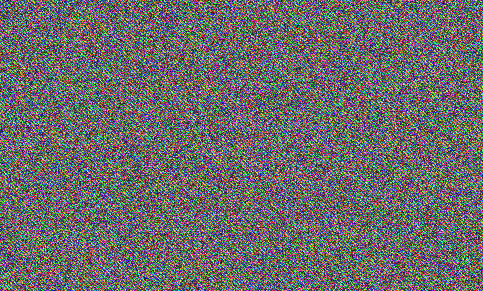

In [125]:
pil_noise

In [ ]:
pil_noise.size

In [126]:
tsfm = transforms.Compose([transforms.CenterCrop(288), transforms.ToTensor()])

In [127]:
img_tfm = tsfm(pil_img)
img_tfm.shape

torch.Size([3, 288, 288])

In [128]:
noise_tfm = tsfm(pil_noise)
noise_tfm.shape

torch.Size([3, 288, 288])

In [129]:
# acts as a function which accepts torch tensor as parameter...
tsfm_to_pil = transforms.ToPILImage()  # still cropped to 288

In [ ]:
tsfm_to_pil(img_tfm)

In [ ]:
tsfm_to_pil(noise_tfm)

#### LBFGS

In [130]:
opt_img_v = V(noise_tfm[None], requires_grad=True)
optimizer = optim.LBFGS([opt_img_v])

In [131]:
m_vgg(V(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = sf.features.clone()  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 512, 36, 36])

In [132]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 0, loss: 3.206321954727173
Iteration: 100, loss: 0.12405452132225037
Iteration: 200, loss: 0.0635819062590599
Iteration: 300, loss: 0.044523727148771286
Iteration: 400, loss: 0.03564801067113876
Iteration: 500, loss: 0.030108409002423286
Iteration: 600, loss: 0.026317641139030457
Iteration: 700, loss: 0.023664066568017006
Iteration: 800, loss: 0.02174776792526245
Iteration: 900, loss: 0.02016463503241539
Iteration: 1000, loss: 0.01889101229608059


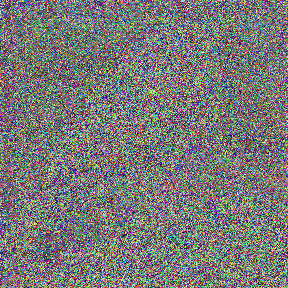

In [141]:
tsfm_to_pil(opt_img_v.detach()[0].cpu())

### Fastai transforms

In [145]:
_, val_tfms = tfms_from_model(vgg16, 288)

In [146]:
img_tfm = val_tfms(img)

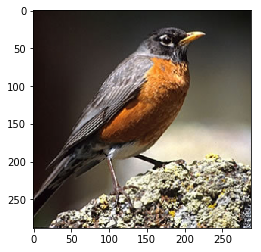

In [147]:
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)))

### LBFGS (Jeremy's method)

In [78]:
m_vgg(V(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = sf.features.clone()  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 512, 36, 36])

In [ ]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)          # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

In [79]:
opt_img_v, optimizer = get_opt()

In [29]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.item()}')
    loss.backward()
    n_iter+=1
    return loss

In [80]:
def actn_loss2(x):
    m_vgg(x)              # calls forward on network and doesn't save results
    #out = V(sf.features)  # chosen layer activations => error: variable does not require grad and does not have a grad_fn
    #out = V(sf.features, requires_grad=True)  # this avoids error but results in no drop in loss...
    out = sf.features  # remove variable to avoid above error and still optimize
    return F.mse_loss(out, targ_v)*1000

In [81]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 0, loss: 4.450213432312012
Iteration: 100, loss: 0.27766063809394836
Iteration: 200, loss: 0.11980466544628143
Iteration: 300, loss: 0.07785244286060333
Iteration: 400, loss: 0.0584888719022274
Iteration: 500, loss: 0.04789469391107559
Iteration: 600, loss: 0.04108455032110214
Iteration: 700, loss: 0.036316532641649246
Iteration: 800, loss: 0.03273368254303932
Iteration: 900, loss: 0.029960712417960167
Iteration: 1000, loss: 0.027652008458971977


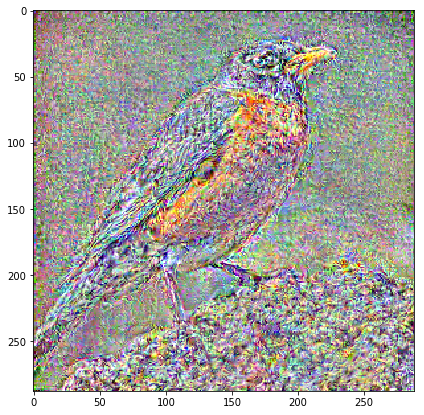

In [82]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Vanilla Backprop, lr=10

In [95]:
def mse_vanilla(input, target):
    for t in range(1,1001):
#         opt.zero_grad()
        m_vgg(input)
        out = sf.features
        loss = torch.nn.functional.mse_loss(out, target)*10000
        loss.backward()
#         opt.step()
        
        if t%100==0:
            print(f'Iteration: {t}, loss: {loss.item()}')
        
#         loss.backward()                # compute gradients
        with torch.no_grad():          # Update weights using gradient descent
            lr=10
            input -= lr * input.grad
            input.grad.zero_()         # Manually zero the gradients after updating weights

In [96]:
opt_img_v, _ = get_opt()

In [97]:
mse_vanilla(opt_img_v, targ_v)

Iteration: 100, loss: 6.915149211883545
Iteration: 200, loss: 4.334028720855713
Iteration: 300, loss: 3.3315320014953613
Iteration: 400, loss: 2.751485824584961
Iteration: 500, loss: 2.3681857585906982
Iteration: 600, loss: 2.148697853088379
Iteration: 700, loss: 1.9504743814468384
Iteration: 800, loss: 1.7706725597381592
Iteration: 900, loss: 1.6843825578689575
Iteration: 1000, loss: 1.520379900932312


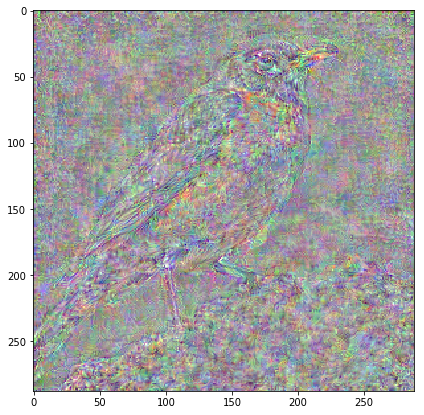

In [98]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Adam optimizer

In [114]:
opt_img_v, _ = get_opt()

In [113]:
def mse_opt(input, target, opt):
    for t in range(1,1001):
        opt.zero_grad()
        m_vgg(input)
        out = sf.features
        loss = F.mse_loss(out, target)*1000
        loss.backward()
        opt.step()
        
        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')

In [115]:
mse_opt(opt_img_v, targ_v, torch.optim.Adam([opt_img_v], lr=1))

Iteration: 100, loss: 1.2934030294418335
Iteration: 200, loss: 0.6621243953704834
Iteration: 300, loss: 0.4459746479988098
Iteration: 400, loss: 0.35176989436149597
Iteration: 500, loss: 0.32396045327186584
Iteration: 600, loss: 0.2798231840133667
Iteration: 700, loss: 0.27142876386642456
Iteration: 800, loss: 0.2400469183921814
Iteration: 900, loss: 0.24382559955120087
Iteration: 1000, loss: 0.21872517466545105


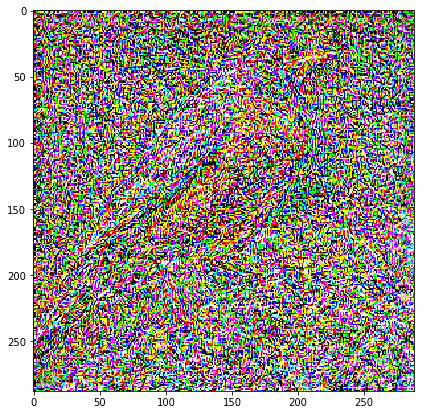

In [116]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### SGD optimizer

In [117]:
opt_img_v, _ = get_opt()

In [118]:
def mse_opt(input, target, opt, sf):
    for t in range(1,1001):
        opt.zero_grad()
        m_vgg(input)
        out = sf.features
        loss = F.mse_loss(out, target)*1000
        loss.backward()
        opt.step()
        
        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')

In [119]:
mse_opt(opt_img_v, targ_v, torch.optim.SGD([opt_img_v], lr=1))

Iteration: 100, loss: 3.6977312564849854
Iteration: 200, loss: 3.3181886672973633
Iteration: 300, loss: 2.9008593559265137
Iteration: 400, loss: 2.640620231628418
Iteration: 500, loss: 2.4550364017486572
Iteration: 600, loss: 2.2844080924987793
Iteration: 700, loss: 2.1509859561920166
Iteration: 800, loss: 2.0300636291503906
Iteration: 900, loss: 1.9297137260437012
Iteration: 1000, loss: 1.847084641456604


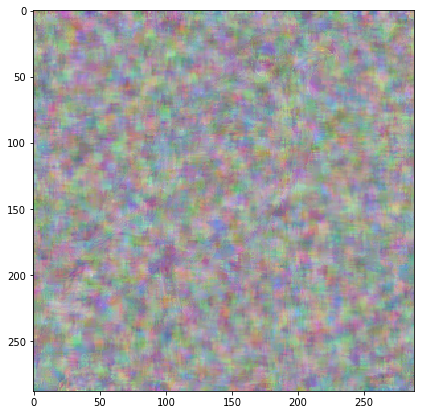

In [120]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Compare results from other activation layers

In [208]:
sf = SaveFeatures(children(m_vgg)[block_ends[2]])   # getting i-th layer as module

In [209]:
m_vgg(V(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = sf.features.clone()  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 256, 72, 72])

In [210]:
opt_img_v, optimizer = get_opt()

In [211]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.item()}')
    loss.backward()
    n_iter+=1
    return loss

In [212]:
def actn_loss3(x):
    m_vgg(x)              # calls forward on network and doesn't save results
    #out = V(sf.features)  # chosen layer activations => error: variable does not require grad and does not have a grad_fn
    #out = V(sf.features, requires_grad=True)  # this avoids error but results in no drop in loss...
    out = sf.features  # remove variable to avoid above error and still optimize
    return F.mse_loss(out, targ_v)*1000

In [213]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: 0, loss: 21.295141220092773
Iteration: 100, loss: 1.1522718667984009
Iteration: 200, loss: 0.7966902852058411
Iteration: 300, loss: 0.6515507698059082
Iteration: 400, loss: 0.5678476095199585
Iteration: 500, loss: 0.5133469104766846
Iteration: 600, loss: 0.47513875365257263
Iteration: 700, loss: 0.4462410807609558
Iteration: 800, loss: 0.4232693016529083
Iteration: 900, loss: 0.4048541486263275
Iteration: 1000, loss: 0.3898264169692993


#### layer 22 - 0.3898264169692993

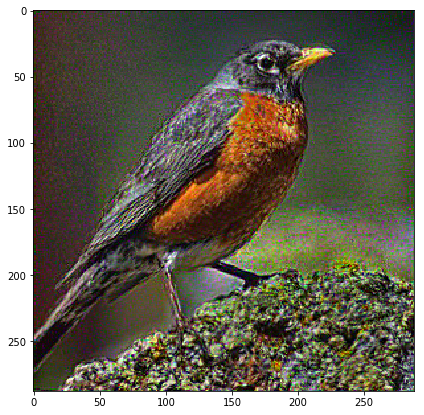

In [214]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

#### layer 42 - 0.27672985196113586

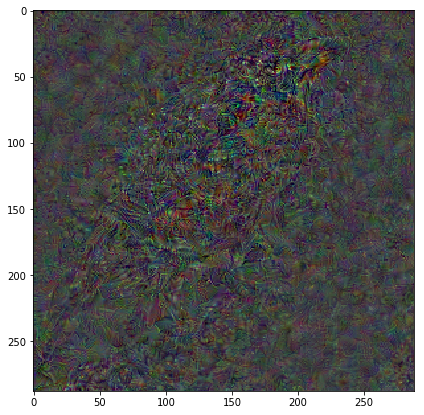

In [207]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

## Style Match

In [18]:
class image():
    shape = (291, 483, 3)
    def __init__(self): self

img = image()
img.shape

(291, 483, 3)

In [19]:
style_fn = PATH/'style'/'starry_night.jpg'
style_img = open_image(style_fn)
style_img.shape, img.shape

((480, 606, 3), (291, 483, 3))

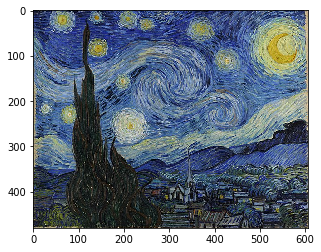

In [11]:
plt.imshow(style_img);

In [20]:
# resize style image to be same size as target image
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [21]:
style = scale_match(img, style_img)
style.shape

(291, 483, 3)

In [58]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img*1.2)[None], requires_grad=True)        # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

In [69]:
opt_img_v, optimizer = get_opt()

In [24]:
# save features for all block_ends -> array of activation layers
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [ ]:
style_tfm = val_tfms(style)

In [ ]:
opt_img_v.max(), opt_img_v.min(), opt_img_v.mean(), opt_img_v.std()

In [25]:
style_tfm.max(), style_tfm.min(), style_tfm.mean(), style_tfm.std()

(2.220636, -2.0941808, -0.21034296, 0.84107596)

In [26]:
m_vgg(V(style_tfm[None]))
targ_styles = [sf.features.clone() for sf in sfs]
[s.shape for s in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [68]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1) # flatten batch (1) and channel, height X width
        return torch.mm(x, x.t())/input.numel()*1e6
    
        #np.square(input.numel())*4  -> normalizer to mse used in the paper...
        
        # matrix multiply w/ transpose
        # normalize by dividing by number of elements (b*c*h*w)
        # results in a tiny number so we multiply by a big number (1e6) to make it more sensible

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

### LBFGS (jeremy's method)

In [70]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.item()}')
    loss.backward()
    n_iter+=1
    return loss

In [71]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [o.features for o in sfs]  # noise image layers
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]  # calc loss at each layer
    return sum(losses)  # add up layers; can do whatever you like really... (subsets, different weightings, etc.)

In [34]:
max_iter = 1000
show_iter = 100
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 0, loss: 231969.875
Iteration: 100, loss: 83.82746124267578
Iteration: 200, loss: 37.83681869506836
Iteration: 300, loss: 24.450523376464844
Iteration: 400, loss: 17.16204261779785
Iteration: 500, loss: 12.594558715820312
Iteration: 600, loss: 9.771913528442383
Iteration: 700, loss: 7.846008777618408
Iteration: 800, loss: 6.621795654296875
Iteration: 900, loss: 5.829718112945557
Iteration: 1000, loss: 5.266290664672852


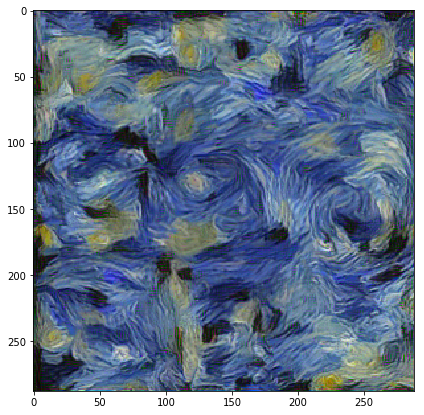

In [35]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### different normalizer to mse used in paper

In [73]:
max_iter = 500
show_iter = 100
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 0, loss: 5.718772888183594
Iteration: 100, loss: 5.290399551391602
Iteration: 200, loss: 4.978143215179443
Iteration: 300, loss: 4.7258830070495605
Iteration: 400, loss: 4.523303031921387
Iteration: 500, loss: 4.36052131652832


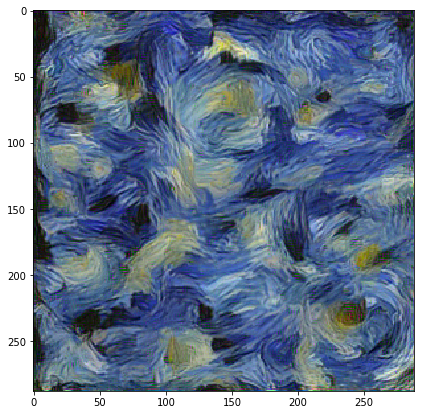

In [74]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Adam optimizer

In [45]:
opt_img_v, _ = get_opt()

In [41]:
def style_loss(inp, targ_feats):
    m_vgg(inp)
    outs = [sf.features for sf in sfs]
    losses = [gram_mse_loss(o,s) for o,s in zip(outs, targ_feats)]
    return sum(losses)

In [42]:
def style_match(input, target, opt):
    for t in range(1,1001):
        opt.zero_grad()
        loss = style_loss(input, target)
        loss.backward()
        opt.step()
        
        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')

In [50]:
style_match(opt_img_v, targ_styles, torch.optim.Adam([opt_img_v], lr=1))

Iteration: 100, loss: 336.36260986328125
Iteration: 200, loss: 131.4864501953125
Iteration: 300, loss: 90.93536376953125
Iteration: 400, loss: 72.48065948486328
Iteration: 500, loss: 60.87267303466797
Iteration: 600, loss: 52.78190994262695
Iteration: 700, loss: 49.03885269165039
Iteration: 800, loss: 41.8602180480957
Iteration: 900, loss: 39.35464096069336
Iteration: 1000, loss: 34.26451110839844


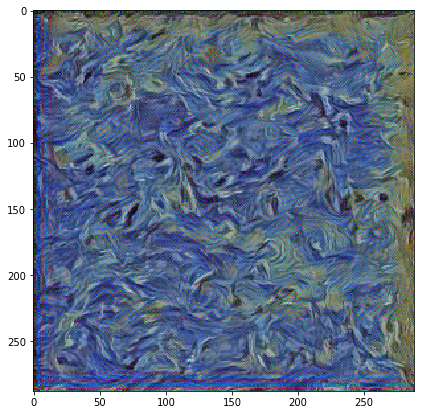

In [51]:
# With Adam & taking batchnorm layers w/ i-1 (instead of relu layers)
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### SGD - failure...

In [52]:
opt_img_v, _ = get_opt()

In [56]:
style_match(opt_img_v, targ_styles, torch.optim.SGD([opt_img_v], lr=1))

Iteration: 100, loss: 2476986.0
Iteration: 200, loss: 2476986.0
Iteration: 300, loss: 2476986.0
Iteration: 400, loss: 2476986.0
Iteration: 500, loss: 2476986.0
Iteration: 600, loss: 2476986.0
Iteration: 700, loss: 2476986.0
Iteration: 800, loss: 2476986.0
Iteration: 900, loss: 2476986.0
Iteration: 1000, loss: 2476986.0


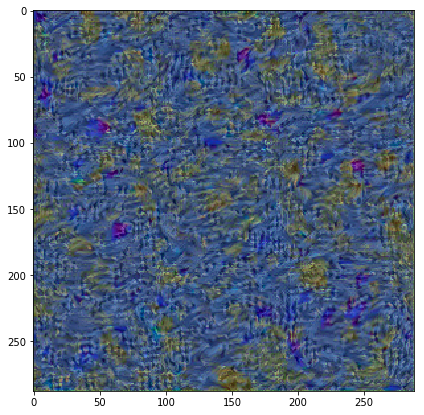

In [85]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

In [ ]:
for sf in sfs: sf.close()  # close out the hook to save memory 

## Style Transfer

In [174]:
opt_img_v, optimizer = get_opt()

In [149]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [175]:
def comb_loss(x):
    # 1e5 => 168.55975341796875
    # 1e6 => 648.6123657226562
    # 1e7 => 2057.2021484375
    m_vgg(opt_img_v)
    outs = [sf.features for sf in sfs]
    style_losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]      # content loss
    content_loss = F.mse_loss(outs[3], targ_vs[3])                        # style losses
    style_loss = sum(style_losses)
#     print(f'content loss: {content_loss}')
#     print(f'style_loss: {style_loss}')
    return (content_loss*1e5) + style_loss                                # losses added together w/ multiplier

In [176]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 0, loss: 230135.4375
Iteration: 100, loss: 411.72705078125
Iteration: 200, loss: 291.5477294921875
Iteration: 300, loss: 246.21080017089844
Iteration: 400, loss: 221.17218017578125
Iteration: 500, loss: 205.15713500976562
Iteration: 600, loss: 193.43063354492188
Iteration: 700, loss: 184.4925994873047
Iteration: 800, loss: 177.9578857421875
Iteration: 900, loss: 172.79563903808594
Iteration: 1000, loss: 168.55975341796875


#### 1e5

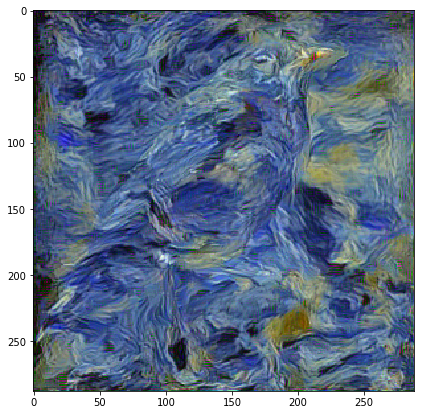

In [177]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e6

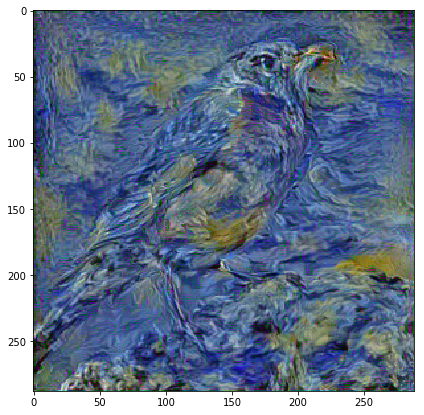

In [173]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e7

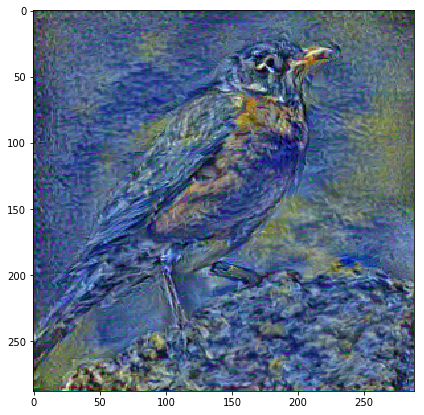

In [169]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

### Try w/ duplicated input image instead of noise

In [187]:
opt_img_v = V(img_tfm.copy()[None], requires_grad=True)
optimizer = optim.LBFGS([opt_img_v])

In [188]:
def comb_loss(x):
    # 1e5 => 168.55975341796875
    # 1e6 => 648.6123657226562
    # 1e7 => 2057.2021484375
    m_vgg(opt_img_v)
    outs = [sf.features for sf in sfs]
    style_losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]      # content loss
    content_loss = F.mse_loss(outs[3], targ_vs[3])                        # style losses
    style_loss = sum(style_losses)
#     print(f'content loss: {content_loss}')
#     print(f'style_loss: {style_loss}')
    return (content_loss*1e4) + style_loss                                # losses added together w/ multiplier

In [189]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 0, loss: 380263.28125
Iteration: 100, loss: 89.0960693359375
Iteration: 200, loss: 56.79451370239258
Iteration: 300, loss: 47.691768646240234
Iteration: 400, loss: 43.21055603027344
Iteration: 500, loss: 40.54647445678711
Iteration: 600, loss: 38.77214050292969
Iteration: 700, loss: 37.56357955932617
Iteration: 800, loss: 36.653324127197266
Iteration: 900, loss: 35.93981170654297
Iteration: 1000, loss: 35.35456085205078


#### 1e4

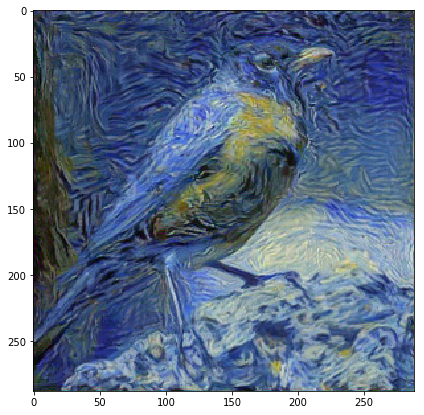

In [190]:
#=> 35.35456085205078
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e5

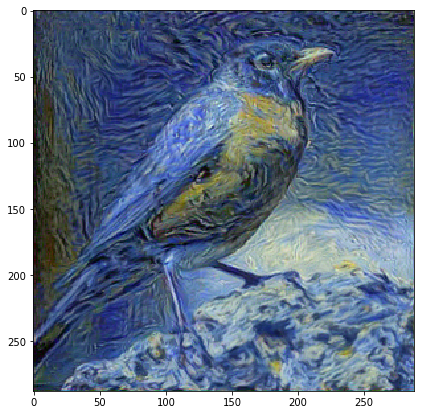

In [181]:
#=> 135.58486938476562
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e6

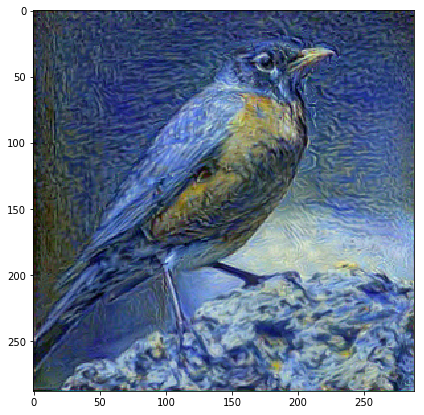

In [186]:
#=> 442.21685791015625
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);